# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras import models, layers, regularizers, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16


# Baseline Model:  Densely Connected Network

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0)
train.head()

,file,target
0,ISIC_1569119,1
1,ISIC_7536704,1
2,ISIC_3696488,1
3,ISIC_3343475,1
4,ISIC_7785723,1


In [3]:
val = pd.read_csv('../data/val.csv', index_col=0)
val.head()

,file,target
0,ISIC_6767569,1
1,ISIC_7312977,1
2,ISIC_1785627,1
3,ISIC_8066110,1
4,ISIC_8838753,1


In [4]:
test = pd.read_csv('../data/test_df.csv', index_col=0)
test.head()

,file,age,site,lesion_id,gender,target,jpg
0,ISIC_0000000,55.0,anterior torso,NaN,female,0,ISIC_0000000.jpg
1,ISIC_0000001,30.0,anterior torso,NaN,female,0,ISIC_0000001.jpg
2,ISIC_0000002,60.0,upper extremity,NaN,female,1,ISIC_0000002.jpg
3,ISIC_0000003,30.0,upper extremity,NaN,male,0,ISIC_0000003.jpg
4,ISIC_0000004,80.0,posterior torso,NaN,male,1,ISIC_0000004.jpg


In [5]:
train_fldr = "../split/train"
val_fldr = "../split/val"

val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 32)

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr, 
        target_size = (256, 256),
        batch_size = 32)

Found 6626 images belonging to 2 classes.
Found 32135 images belonging to 2 classes.


In [6]:
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [7]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 32
Number of validation samples: 32
train_images shape: (32, 256, 256, 3)
train_labels shape: (32, 2)
val_images shape: (32, 256, 256, 3)
val_labels shape: (32, 2)


In [8]:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)

(32, 196608)
(32, 196608)


In [9]:
train_y = np.reshape(train_labels[:,0], (32,1))
val_y = np.reshape(val_labels[:,0], (32,1))

# Densely Connected Network

In [10]:
model = models.Sequential()
model.add(layers.Dense(20, activation = 'relu', input_shape = (196608, ))) # 2 hidden layers
model.add(layers.Dense(7, activation = 'relu'))
model.add(layers.Dense(5, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [11]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

history = model.fit(train_img,
                    train_y,
                    epochs = 50,
                    batch_size = 32,
                    validation_data = (val_img, val_y))

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.6451 - accuracy: 0.8438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8037 - auc_1: 0.2944 - val_loss: 9.4682 - val_accuracy: 0.9688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_auc_1: 0.0312
Epoch 2/50
1/1 [==============================] - 0s 71ms/step - loss: 54.9086 - accuracy: 0.8438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - auc_1: 0.1562 - val_loss: 10.8937 - val_accuracy: 0.9688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_auc_1: 0.0312
Epoch 3/50
1/1 [==============================] - 0s 75ms/step - loss: 62.8496 - accuracy: 0.8438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - auc_1: 0.1562 - val_loss: 9.0621 - val_accuracy: 0.9688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_auc_1: 0.0312
Epoch 4/50
1/1 [==============================] - 0s 74ms/step - loss: 51.9458 - acc

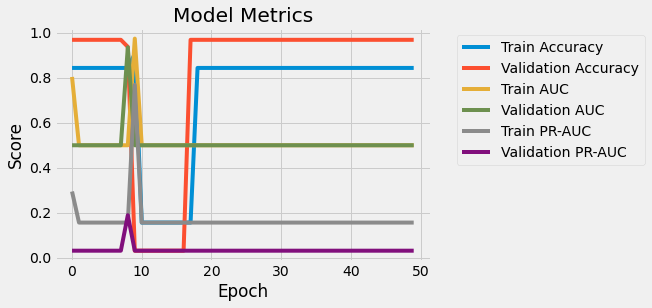

In [12]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model Metrics')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train AUC', 'Validation AUC', 'Train PR-AUC', 'Validation PR-AUC'], loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3932180   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 3,932,373
Trainable params: 3,932,373
Non-trainable params: 0
_________________________________________________________________


In [14]:
results_train = model.evaluate(train_img, train_y)

1/1 [==============================] - 0s 25ms/step - loss: 0.5960 - accuracy: 0.8438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - auc_1: 0.1562


In [15]:
results_val = model.evaluate(val_img, val_y)

1/1 [==============================] - 0s 24ms/step - loss: 0.5560 - accuracy: 0.9688 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - auc_1: 0.0312


In [16]:
results_train

[0.5959755182266235, 0.84375, 0.0, 0.0, 0.5, 0.15625]

In [17]:
results_val

[0.5560145378112793, 0.96875, 0.0, 0.0, 0.5, 0.03125]

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3932180   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 3,932,373
Trainable params: 3,932,373
Non-trainable params: 0
_________________________________________________________________


# Basic CNN

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3), padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
# padding = same for convolutions
# batchnormalize between convolution and activation
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [19]:
history = model.fit(train_images,
                    train_y,
                    epochs = 30,
                    batch_size = 32,
                    validation_data = (val_images, val_y))

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.7453 - accuracy: 0.1562 - precision_1: 0.1562 - recall_1: 1.0000 - auc_2: 0.1815 - auc_3: 0.0918 - val_loss: 44.4129 - val_accuracy: 0.9688 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_2: 0.5000 - val_auc_3: 0.0312
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 255.9830 - accuracy: 0.8438 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_2: 0.5000 - auc_3: 0.1562 - val_loss: 189.6766 - val_accuracy: 0.0312 - val_precision_1: 0.0312 - val_recall_1: 1.0000 - val_auc_2: 0.5000 - val_auc_3: 0.0312
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 169.1608 - accuracy: 0.1562 - precision_1: 0.1562 - recall_1: 1.0000 - auc_2: 0.5000 - auc_3: 0.1562 - val_loss: 0.3375 - val_accuracy: 0.9688 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_2: 0.5000 - val_auc_3: 0.0312
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 2.7

In [20]:
results_train = model.evaluate(train_images, train_y)

1/1 [==============================] - 0s 311ms/step - loss: 0.3151 - accuracy: 0.8438 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_2: 0.9407 - auc_3: 0.7989


In [21]:
results_val = model.evaluate(val_images, val_y)

1/1 [==============================] - 0s 310ms/step - loss: 0.1685 - accuracy: 0.9688 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_2: 0.8548 - auc_3: 0.0945


In [22]:
results_train

[0.31509509682655334, 0.84375, 0.0, 0.0, 0.940740704536438, 0.7989484071731567]

In [23]:
results_val

[0.16848082840442657,
 0.96875,
 0.0,
 0.0,
 0.8548387289047241,
 0.09453490376472473]

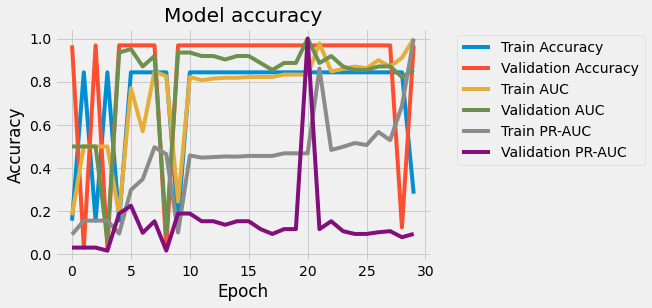

In [24]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['auc_2'])
plt.plot(history.history['val_auc_2'])
plt.plot(history.history['auc_3'])
plt.plot(history.history['val_auc_3'])
plt.plot
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train AUC', 'Validation AUC', 'Train PR-AUC', 'Validation PR-AUC'], loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

# VGG16 Model

In [25]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = False

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(inputs=input_, outputs=last_layer)

model.compile(optimizer = Adam(learning_rate=0.01), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

train_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale = 1./255)

train_set = train_data_gen.flow_from_directory(train_fldr,
                                               target_size = (256, 256),
                                               batch_size = 32,
                                               class_mode = 'binary')
val_set = val_data_gen.flow_from_directory(val_fldr,
                                           target_size = (256, 256),
                                           batch_size = 32,
                                           class_mode = 'binary')


# score = model.evaluate_generator(test_set, len(test_set))

# for idx, metric in enumerate(model.metrics_names):
    # print("{}: {}".format(metric, score[idx]))                    

Found 32135 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.


In [37]:
history = model.fit(train_set,
          epochs = 5,
          steps_per_epoch = 20,
          verbose = 1,
          validation_data = val_set,
          validation_steps = 20)

Epoch 1/5
20/20 [==============================] - 489s 25s/step - loss: 0.2353 - accuracy: 0.9281 - precision_2: 0.9580 - recall_2: 0.9544 - auc_4: 0.9534 - auc_5: 0.9831 - val_loss: 0.2236 - val_accuracy: 0.9656 - val_precision_2: 0.9840 - val_recall_2: 0.9809 - val_auc_4: 0.6174 - val_auc_5: 0.9856
Epoch 2/5
20/20 [==============================] - 461s 24s/step - loss: 0.3094 - accuracy: 0.9406 - precision_2: 0.9658 - recall_2: 0.9621 - auc_4: 0.9356 - auc_5: 0.9758 - val_loss: 0.1594 - val_accuracy: 0.9875 - val_precision_2: 0.9875 - val_recall_2: 1.0000 - val_auc_4: 0.4976 - val_auc_5: 0.9874
Epoch 3/5
20/20 [==============================] - 453s 23s/step - loss: 0.6371 - accuracy: 0.9000 - precision_2: 0.9346 - recall_2: 0.9452 - auc_4: 0.8777 - auc_5: 0.9544 - val_loss: 0.4459 - val_accuracy: 0.9719 - val_precision_2: 0.9734 - val_recall_2: 0.9984 - val_auc_4: 0.4976 - val_auc_5: 0.9733
Epoch 4/5
20/20 [==============================] - 429s 22s/step - loss: 0.3480 - accuracy:

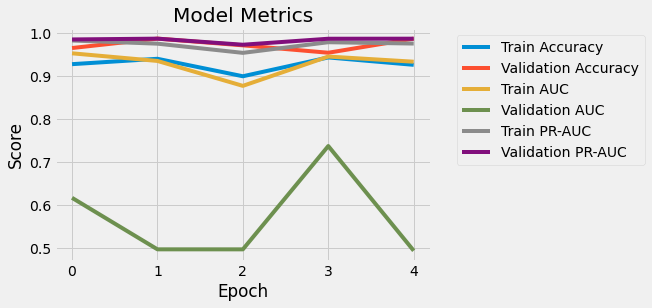

In [40]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['auc_4'])
plt.plot(history.history['val_auc_4'])
plt.plot(history.history['auc_5'])
plt.plot(history.history['val_auc_5'])
plt.title('Model Metrics')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train AUC', 'Validation AUC', 'Train PR-AUC', 'Validation PR-AUC'], loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
plt.plot